<div style="background: navy; color: white; padding: 20px">


# $\S 4$: Market Regime Detection with Rough Path Signatures: Motivating examples

In this notebook, we step through the examples shown in Section 4 of the paper "Non-parametric online market regime detection and regime clustering for multidimensional and path-dependent data structures".

<div style="background: navy; color: white; padding: 20px">

### Imports

In [1]:
import numpy as np
import torch.cuda

from src.generators.config import ModelConfig
from src.testing import TestConfig
from src.testing.discriminators import GeneralMMDDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.mmd_test_functions import alpha_score_function, get_beliefs_from_config
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result, plot_path_test_threshold
from src.utils.Config import Config
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path, plot_scores, plot_beliefs
from src.utils.helper_functions.test_helper_functions import get_memberships, get_alphas, get_sub_paths, \
    get_grouped_paths

np.random.seed(1)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Realistically, you will need GPU support.

## $\S 4.1$ Synthetic, single-class beliefs.

In this section of the notebook, we test the MMD online detector with some synthetic examples. Here we only define one set of beliefs held by the user. 


#### Choice of models.
One is able to choose from the models <code>["gbm", "merton", "rBergomi", "heston", "rough_heston"]</code>. See the documentation for how the parameter vectors are defined. 

#### Choice of detection algorithms. 

We provide two main types of detection algorithms: those with parametric beliefs, non-parametric beliefs, or progressive (auto-updating) beliefs, where beliefs are built as the test path is observed.

The class <code>GeneralMMDDetector</code> performs online regime detection with parametric beliefs. The class <code>AutoEvaluator</code> performs online regime detection with non-parametric beliefs.

##### Note:

Results from Subsections 4.3, 4.4 can also be obtained from below by changing the related parameters. For instance, for non-ensemble evaluation as per Subsection 4.3, change the <code>metric_type</code> configuration of the <code>generalmmddetector_kwargs</code> dictionary to <code>scoring</code> instead of the default <code>mmd</code>. Naturally, you will then have to provide two beliefs instead of the standard one (as outlined in the paper).

For Subsection 4.4, just change the belief models (and parameters), and the regime-switching model pairs (and parameters).

<div style="background: navy; color: white; padding: 20px">

## 1. Set configurations

We begin by choosing the configurations one wishes to use to run the experiment.

Configurations to do with -
1. Testing (number of paths, path lengths, types of paths...) are located in <code>TestConfig</code>,
2. Discriminator processes (type of algorithm and associated hyperparameters) are located in <code>ProcessorConfig</code>,
3. Path generation arguments (size of mesh per year, and whether to attach volatility process or not) are located in <code>ModelConfig</code>,
4. Path transformation arguments are located in <code>PathTransformerConfig</code>, and
5. Synthetic regime change partitioning arguments are located in <code>RegimePartitionerConfig</code>.

In [3]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()

## Testing arguments
model_config.override_args({
    "year_mesh": 7*252,          # Grid mesh size (as a fraction of a year), so dt=1/year_mesh
    "attach_volatility": False   # Whether to include the volatility process
})


T   = 4                         # Time to simulate regime-changed path until
dim = 10                        # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment
 
gbm_params_h0 = [0, 0.2]        # \theta = (\mu, \sigma)
gbm_params_h1 = [0, 0.3]        # Same as above

rB_params_h0  = [0.03, 0.5, -0.7, 0.4]  # \theta = (\xi_0, \nu, \rho, H)
rB_params_h1  = [0.03, 0.5, -0.7, 0.3]  # Same as above

belief_params = [[gbm_params_h0 for _ in range(dim)]]
model_pair_params = [[gbm_params_h0 for _ in range(dim)], [gbm_params_h1 for _ in range(dim)]]

test_config.override_args({
    "n_steps": 16,                          # Length of regime paths (h_1)
    "n_paths": 8,                           # Number of paths in an ensemble (h_2)
    "offset" : 0,                           # Deprecated. Parameter that allowed for overlapping paths to be taken
    "weight_factor": 1,                     # Value to make more recent paths more prominent in MMD calculation (larger values).
    "belief_models": ["gbm"],               # Model types for \mathfrak{P} = (\mathfrak{P}_1, \dots, \mathfrak{P}_k)
    "model_pair_names": ["gbm", "gbm"],     # Switching models
    "belief_params": belief_params,         # Parameters associated to beliefs
    "model_pair_params": model_pair_params, # Parameters associated to switching models
    "path_bank_size": 100000                # Number of paths beliefs are comprised of
})

## Path transformation arguments. See the documentation for explicit detail on each transformation.
path_transformer_config.set_transformations({
    "standardise_path_transform":    (True , 0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True , 0, {}),
    "time_difference_transform":     (False, 0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False , 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [(1/dt)**0.5 for _ in range(dim)]}),
    "cumulant_transform":            (False , 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})


path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

## Detector arguments. Again, see the configuration for specific details regarding each parameter. We give some basic ones here
processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,                          # Number of atoms in bootstrapped estimate of null distribution of MMDs
        "n_evaluations": 1,                      # When evaluating ensemble paths, number of evaluations of the null MMD
        "metric_kwargs": Config(**{
            "kernel_type": "linear",             # Static kernel type
            "metric_type": "mmd",                # "mmd" or "scoring"
            "sigmas": [2.5e-1],                  # Smoothing hyperparameters. If len(sigmas) == 2, rank 2 MMD is used
            "dyadic_orders": [2],                # Dyadic orders of associated PDE solver. If rank 2 MMD is used, len(dyadic_orders) == 2
            "lambd": 5e-2                        # Regularization parameter for conditional mean embedding
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "autoevaluator_kwargs": Config(**{
        "metric_kwargs": Config(**{
            "kernel_type": "linear",             # Static kernel type
            "metric_type": "mmd",                # "mmd" or "scoring"
            "sigmas": [2.5e-1],                  # Smoothing hyperparameters. If len(sigmas) == 2, rank 2 MMD is used
            "dyadic_orders": [2],                # Dyadic orders of associated PDE solver. If rank 2 MMD is used, len(dyadic_orders) == 2
            "lambd": 5e-2                        # Regularization parameter for conditional mean embedding
        }),
        "n_scores": 50,                          # Number of scores used to populate the null distribution
        "evaluator_kwargs": Config(**{
            "lags": [-1]                         # Number of lagged ensembles to compare to
        })
    }),
    "alpha_value": 0.95,                         # Confidence threshold
    "device": device,                            # GPU/CPU flag for setting torch tensors
    "overwrite_prior": True                      # Whether to regenerate bootstrapped prior belief distribution, or to use a saved one.
})

## Regime switching arguments
regime_config.override_args({
    "n_regime_changes": 5,                      # Number of regime changes
    "f_length_scale"  : 0.5,                    # If "type" is "fixed_length", fraction of a year regime change persists for
    "type"            : "random_on_off_steps",  # "random_on_off_steps": changes as described in paper. "fixed_length": as above
    "r_on_args"       : ["poisson", 2],         # Z_1 \sim \mathrm{Po}(\lambda_1)
    "r_off_args"      : ["poisson", 1/30],      # Z_2 \sim \mathrm{Po}(\lambda_2)
    "r_min_distance"  : 16,                     # Minimum number of steps of length h_1 regime must persist for
    "r_min_gap"       : 16                      # Minimum number of steps of length h_1 until a new regime can begin.
})

path_transformer = PathTransformer(path_transformer_config)

<div style="background: navy; color: white; padding: 20px">

## 2. Derive beliefs and initialize detector

We first derive our (parametric) beliefs $\mathfrak{P} = (\mathfrak{P}_1, \dots, \mathfrak{P}_k)$. One can increase the number of beliefs by changing the <code>belief_models</code> and associated <code>belief_params</code> in the <code>TestConfig</code> object.

We can then generate our null beliefs $\mathfrak{D} = (\mathfrak{D}_1, \dots, \mathfrak{D}_k)$ and associate these to a <code>Detector</code> object, which uses the MMD with the specified scaling and static kernel as a metric on path space to detect different regimes.

In [4]:
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)

In [5]:
# Instantiate Detector object
general_detector = GeneralMMDDetector(
    beliefs          = beliefs, 
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|██████████| 100000/100000 [00:14<00:00, 6776.55it/s]


Metric initialized. MMD1, kernel = linear, dyadic_order = 2


0it [00:00, ?it/s]c:\users\zacha\dropbox\kings-work\project-code\mmd-goursat-problem\venv\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
512it [00:06, 84.00it/s] 


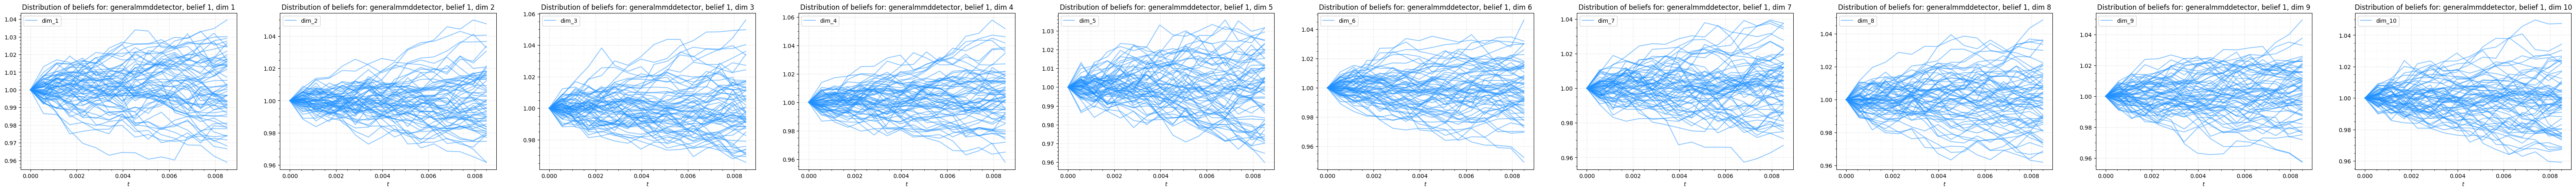

In [6]:
# Plot belief paths
plot_beliefs(general_detector, reverse=False, transformed=False)

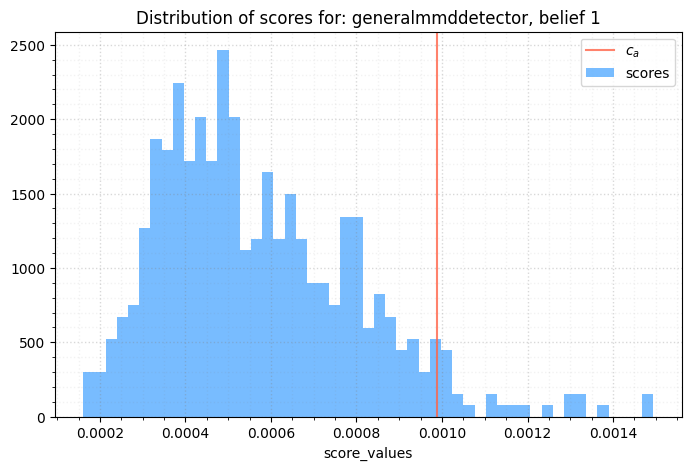

In [7]:
# Show beliefs as histogram(s)
plot_scores(general_detector, reverse=False)

<div style="background: navy; color: white; padding: 20px">


### 3. Build test detection path

In [8]:
# Generate path for testing
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=test_config.n_steps)
test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

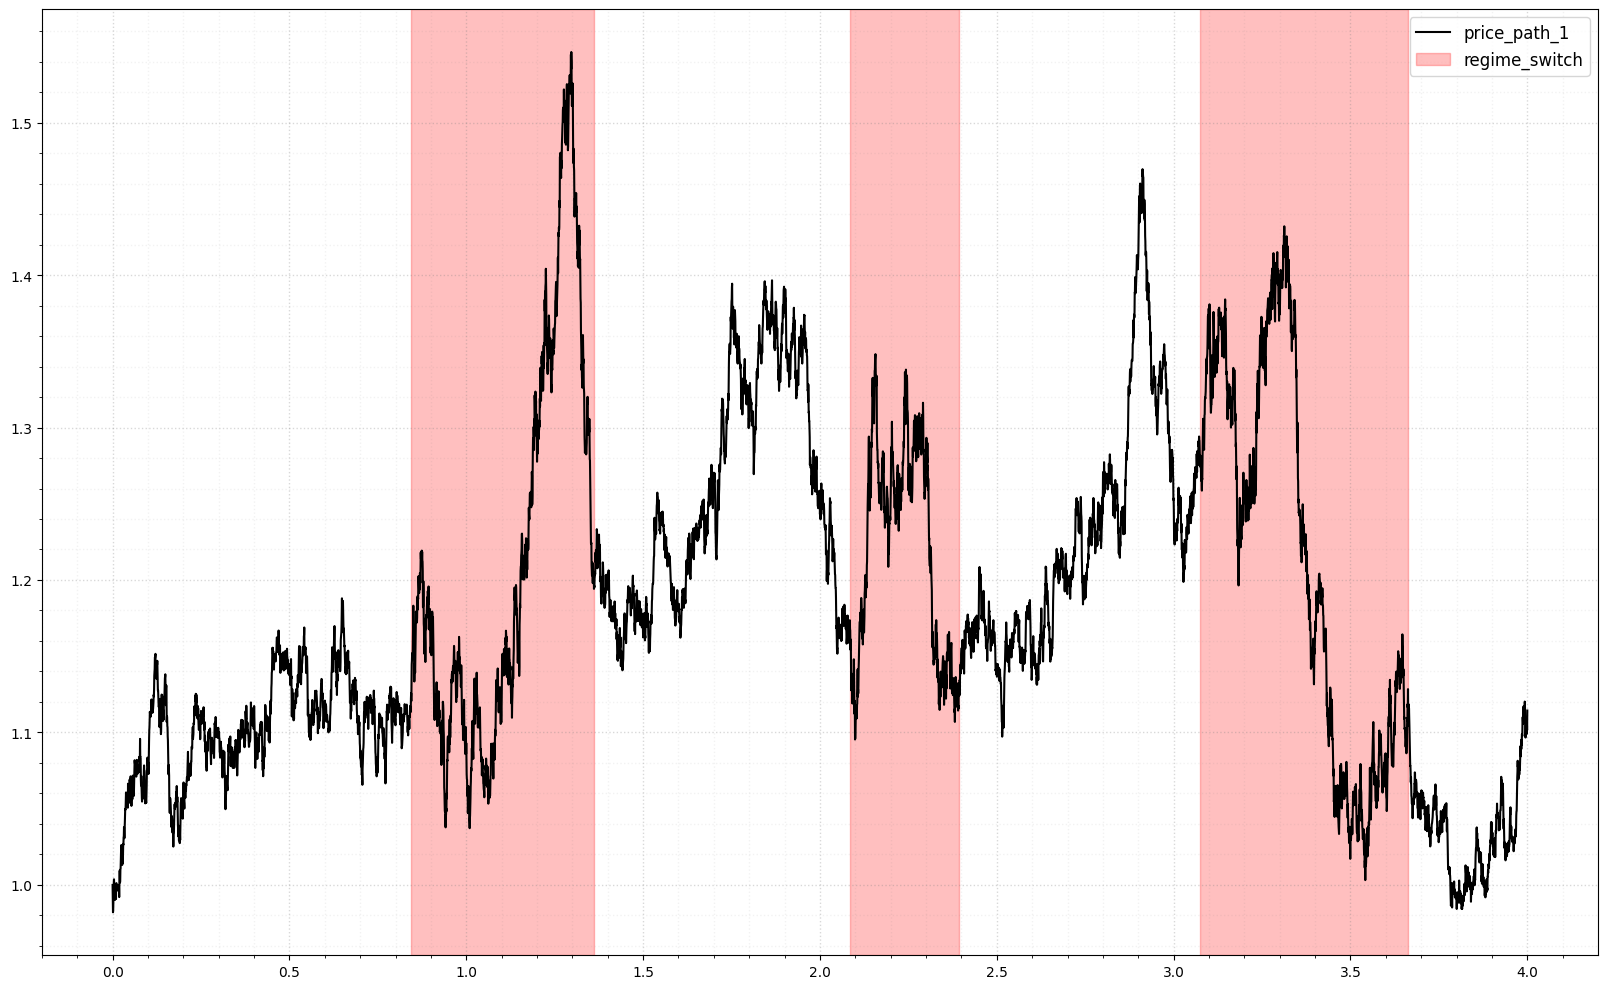

In [9]:
_, regime_changes, _ = regime_partitioner.changes_to_times()

plot_regime_change_path(test_path, regime_changes, log_returns=False, one_dim=True)

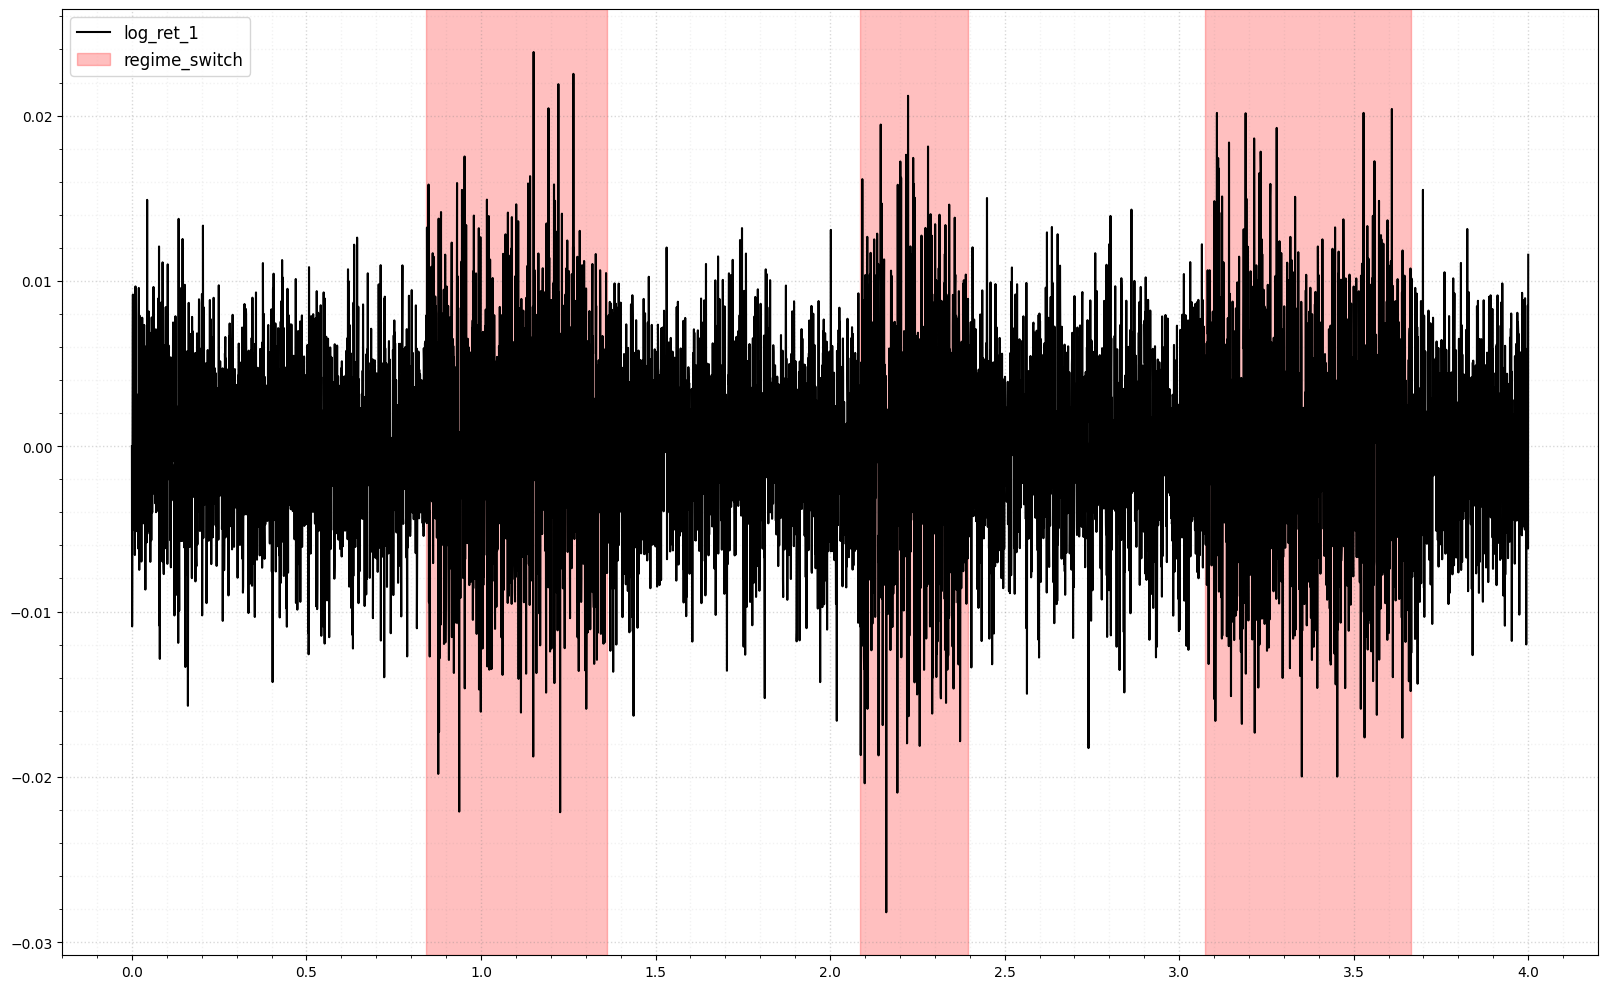

In [10]:
plot_regime_change_path(test_path, regime_changes, log_returns=True, one_dim=True)

<div style="background: navy; color: white; padding: 20px">


### 4. Run Detector over generated path

In [11]:
general_scores_array = general_detector.evaluate_path(test_path, evaluation="total")

100%|██████████| 434/434 [00:03<00:00, 123.15it/s]


<div style="background: navy; color: white; padding: 20px">


### 5. Plot and report results

In [12]:
# Extract sub paths for score functions 
sub_paths = get_sub_paths(test_path, test_config.n_steps, test_config.offset)
c_alpha_g = general_detector.critical_value

# Get alpha scores for test thresholds
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "mmd":
    _n_paths      = test_config.n_paths
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    memberships   = get_memberships(mmd_paths)
    mmd_alphas_g  = get_alphas(memberships, general_scores_array, c_alpha_g)
else:
    _n_paths      = 1
    memberships   = np.array([[i] for i in range(sub_paths.shape[0])])
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    mmd_alphas_g  = np.array([general_scores_array[1, :] - general_scores_array[2, :] >= 0]).astype(float)

path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

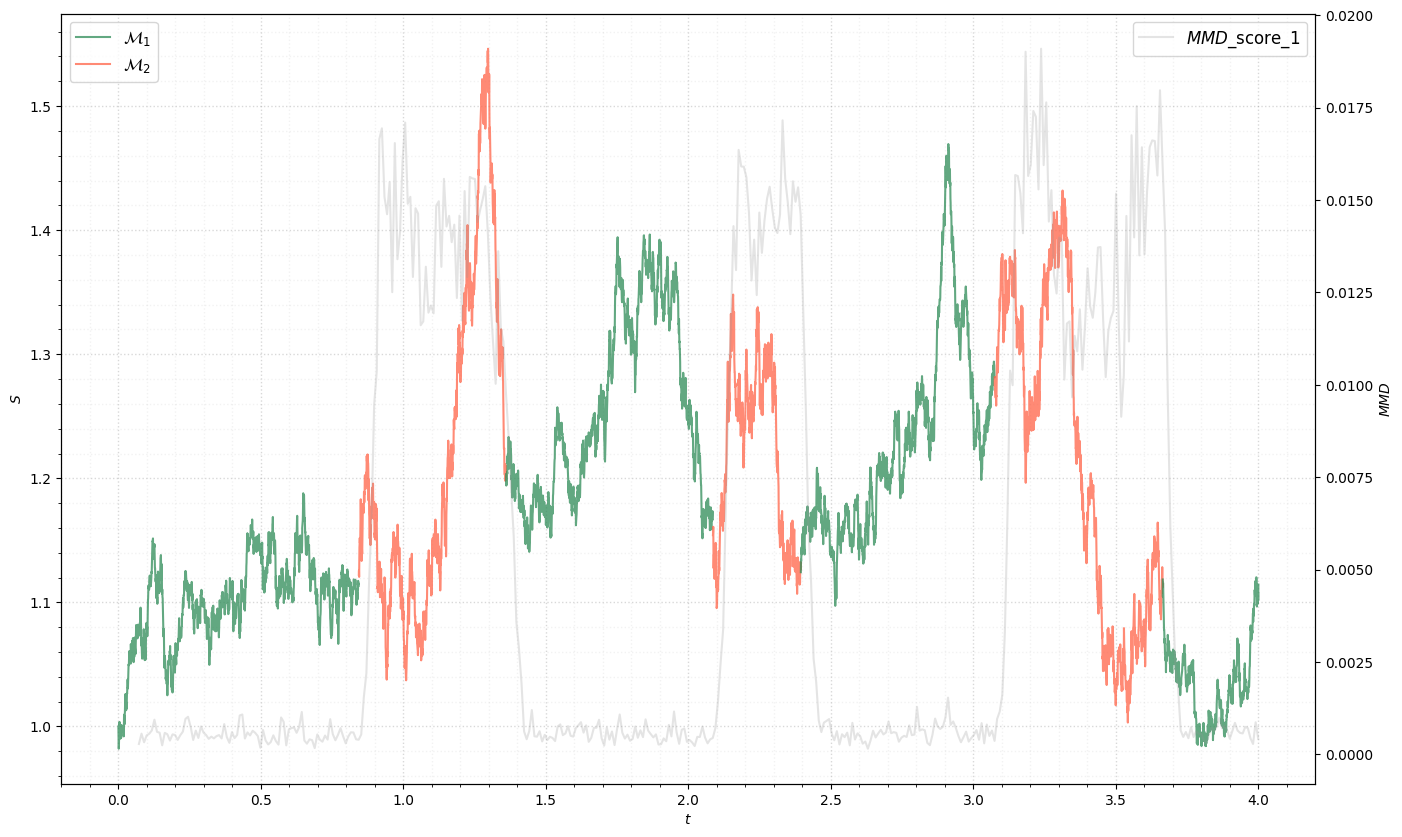

In [13]:
# Plot MMD scores
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "scoring":
    index = general_scores_array[0, :]
    this_score_array = np.vstack([index, general_scores_array[1, :] - general_scores_array[2, :]])
    
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)
else:
    plot_path_experiment_result(test_path, general_scores_array, path_splits_mesh, diff=False)

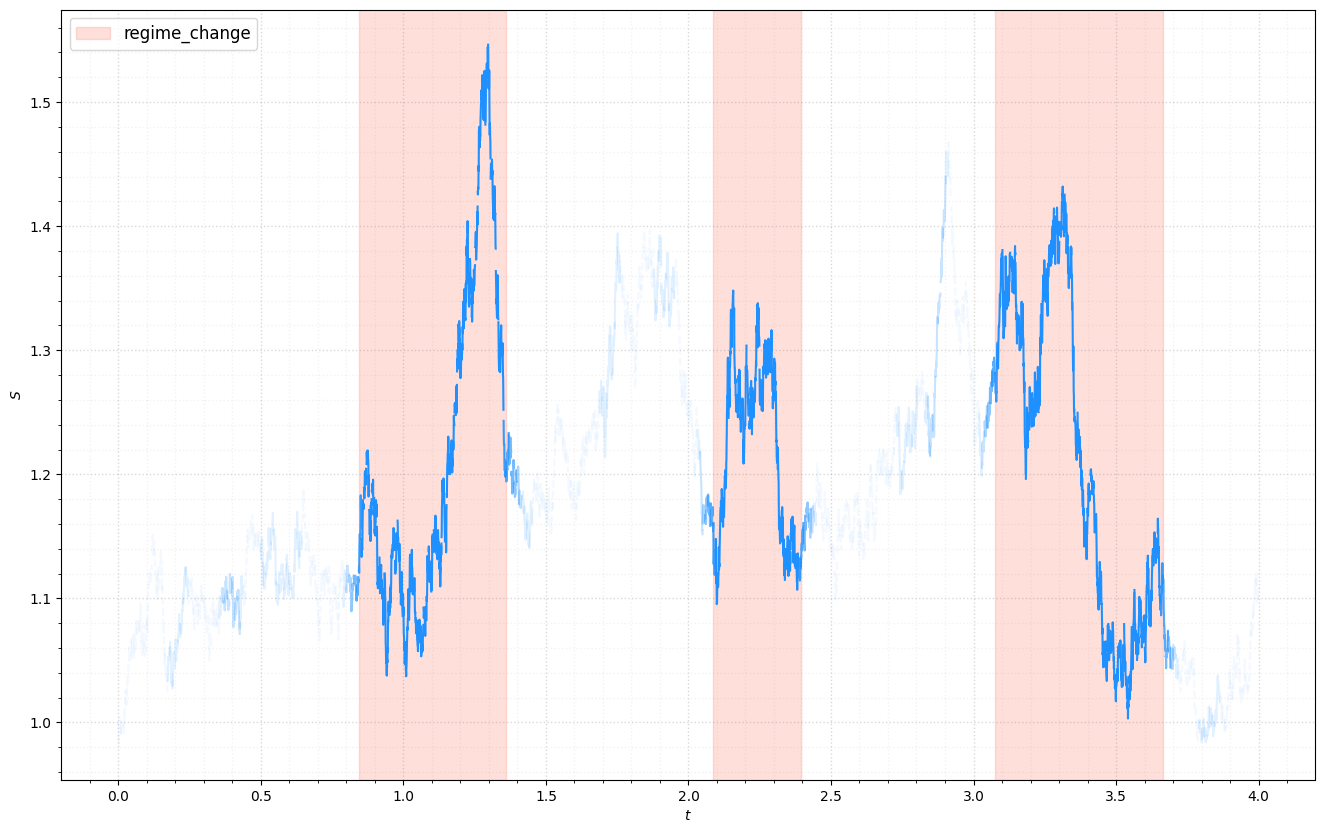

In [14]:
# Plot test threshold performance
for alphas in mmd_alphas_g:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

In [18]:
general_scores_dict = alpha_score_function(
    regime_changes = regime_partitioner.regime_changes, 
    path_length    = len(test_path), 
    memberships    = memberships,
    test_alphas    = mmd_alphas_g[0, :] ,
    test_data      = [test_config.n_steps, test_config.offset, _n_paths]
)

print("General_MMD_Detector scores")
for k, v in general_scores_dict.items():
    print("{}: {:.4f}%".format(k, v*100))

General_MMD_Detector scores
regime_on: 99.6394%
regime_off: 90.2632%
total: 93.5799%


<div style="background: navy; color: white; padding: 20px">


## $\S 4.2$: An example of multiclass beliefs

Here, we show how multi-class beliefs are used, with a simple toy example. 

In particular we set three different kinds of beliefs: low-, medium- and high-volatilty, corresponding to volatility parameters $\sigma_1 < \sigma_2 < \sigma_3$. We then construct a regime path by uniformly sampling over $[\sigma_1, \sigma_3]$ and compare the corresponding MMD/scoring rule values against each of the beliefs. 

This section follows in the same way as the steps above. All configuration values are the same as previously outlined.

In [19]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()


model_config.override_args({
    "year_mesh": 7*252,
    "attach_volatility": False
})


T   = 10                        # Time to simulate regime-changed path until
dim = 1                         # Dimensionality of simulated paths 
S0  = [1. for _ in range(dim)]  # Initial value of simulated paths
dt  = 1/model_config.year_mesh  # Size of path increment

n_model_pairs = 10                # Number of changes
low_vol       = 0.1               # \sigma_1
med_vol       = 0.2               # \sigma_2
high_vol      = 0.4               # \sigma_3

rc_params     = np.linspace(low_vol, high_vol, n_model_pairs)

std_regime_params = [0.2 for _ in range(n_model_pairs)]
all_params        = np.zeros(2*n_model_pairs)
all_params[::2]   = std_regime_params
all_params[1::2]  = rc_params
 
test_config.override_args({
    "n_steps": 8,
    "n_paths": 16,
    "offset" : 0,
    "weight_factor": 1,
    "belief_models": ["gbm", "gbm", "gbm"],
    "model_pair_names": ["gbm" for _ in range(2*n_model_pairs)],
    "belief_params": [[[0., low_vol] for _ in range(dim)], [[0., med_vol] for _ in range(dim)], [[0., high_vol] for _ in range(dim)]],
    "model_pair_params": [[[0., vol] for _ in range(dim)] for vol in all_params],
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True,  0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True,  0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}), 
    "scaling_transform":             (False, 0, {"sigmas": [np.power((1/dt), 5e-1) for _ in range(dim)]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (True, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})

path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "kernel_type": "linear",
            "metric_type": "mmd",
            "sigmas": [1e0],  
            "dyadic_orders": [2],  
            "lambd": 5
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "alpha_value": 0.95,
    "device": device,
    "overwrite_prior": True
})


regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5, 
    "type"            : "random_on_off_steps", 
    "r_on_args"       : ["poisson", 2],
    "r_off_args"      : ["poisson", 1/64],
    "r_min_distance"  : 20,
    "r_min_gap"       : 20
})

path_transformer = PathTransformer(path_transformer_config)

In [20]:
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)

100%|██████████| 100000/100000 [00:11<00:00, 8871.53it/s]


In [21]:
# Instantiate Detector object
sigker_detector = GeneralMMDDetector(
    beliefs          = beliefs, 
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|██████████| 100000/100000 [00:01<00:00, 58914.18it/s]


Metric initialized. MMD1, kernel = linear, dyadic_order = 2


512it [00:03, 158.67it/s]
512it [00:03, 160.26it/s]
512it [00:03, 163.53it/s]


In [22]:
# Generate path for testing
regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=test_config.n_steps)
test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

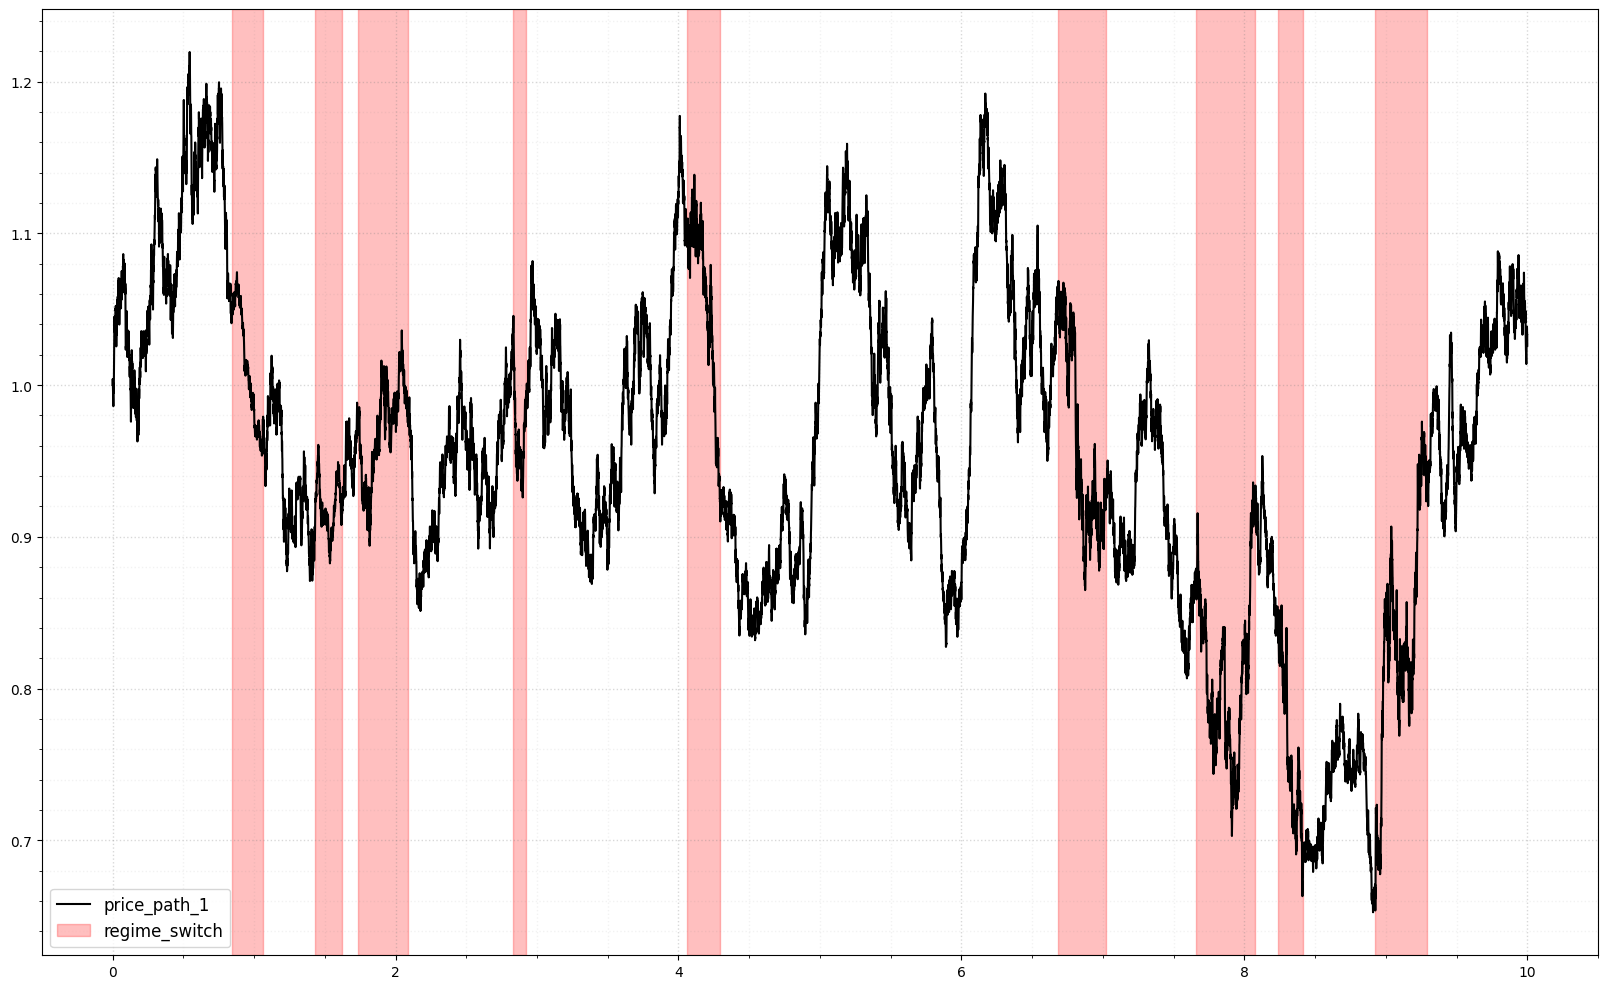

In [23]:
_, regime_changes, _ = regime_partitioner.changes_to_times()

plot_regime_change_path(test_path, regime_changes, log_returns=False, one_dim=True)

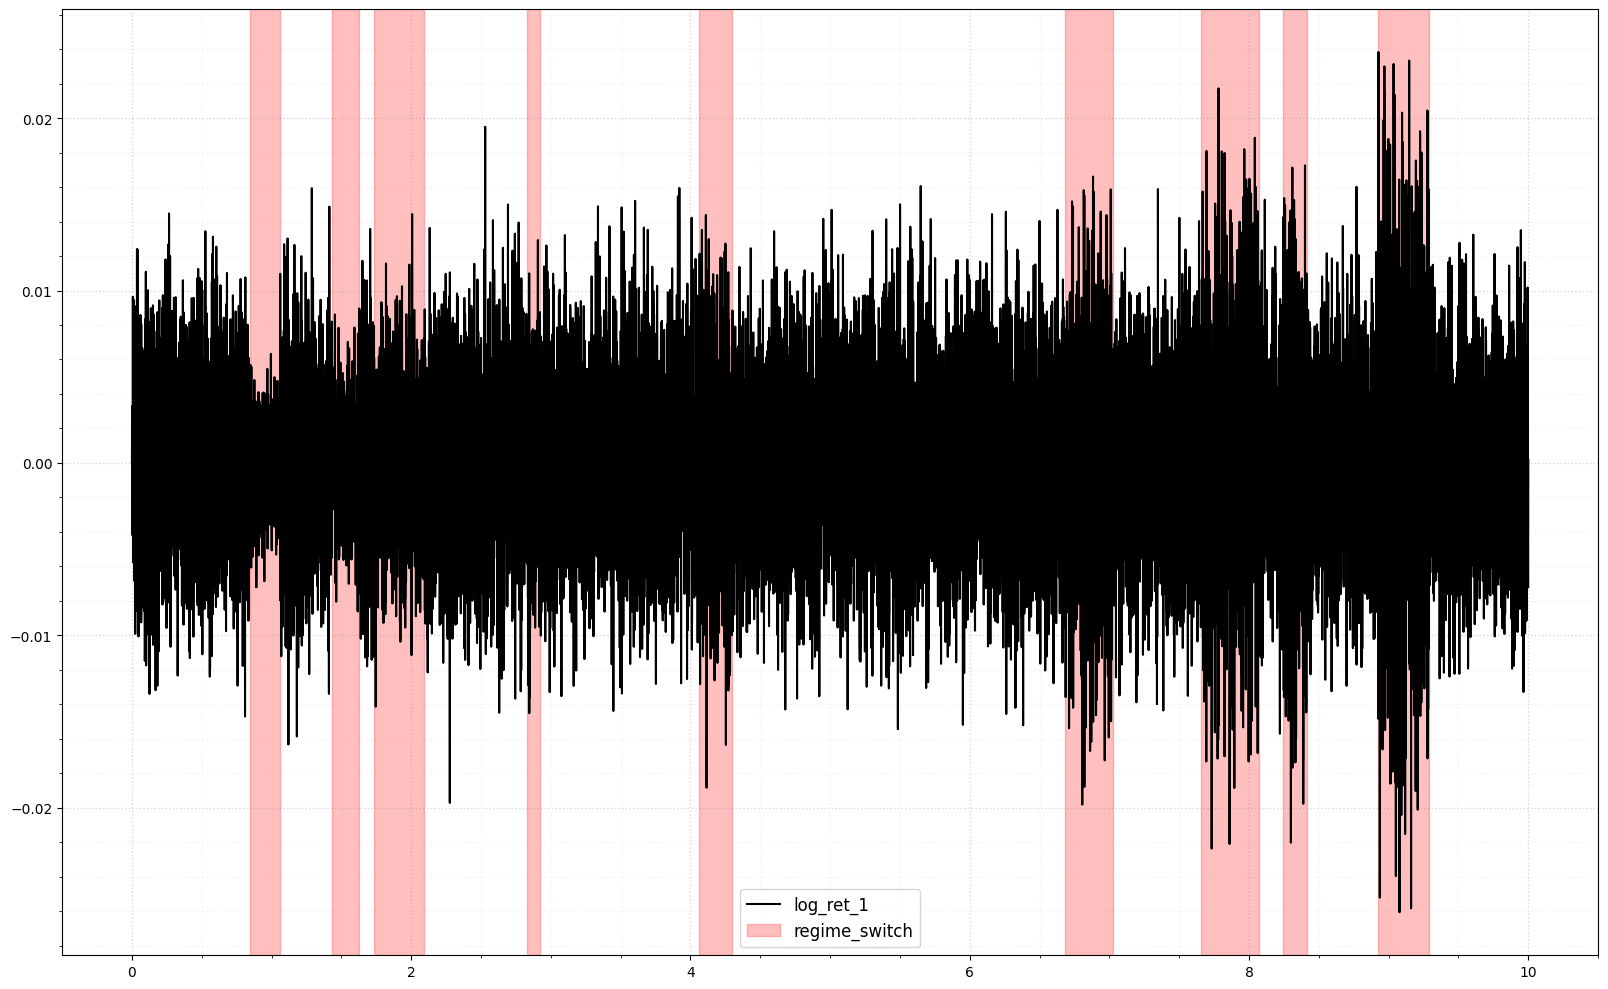

In [24]:
plot_regime_change_path(test_path, regime_changes, log_returns=True, one_dim=True)

In [25]:
multiclass_score_array = sigker_detector.evaluate_path(test_path, evaluation="total")

100%|██████████| 2190/2190 [00:14<00:00, 148.72it/s]


In [26]:
# Extract sub paths for score functions 
sub_paths = get_sub_paths(test_path, test_config.n_steps, test_config.offset)
c_alpha_g = sigker_detector.critical_value

# Get alpha scores for test thresholds
if processor_config.generalmmddetector_kwargs.metric_kwargs.metric_type == "mmd":
    _n_paths      = test_config.n_paths
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    memberships   = get_memberships(mmd_paths)
    mmd_alphas_g  = get_alphas(memberships, multiclass_score_array, c_alpha_g)
else:
    _n_paths      = 1
    memberships   = np.array([[i] for i in range(sub_paths.shape[0])])
    mmd_paths     = get_grouped_paths(sub_paths, _n_paths)
    mmd_alphas_g  = 1.0*np.array([(gsc >= cv[0]) + (gsc <= cv[1]) for gsc, cv in zip(general_scores_array[1:], c_alpha_g)])

path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist] 
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

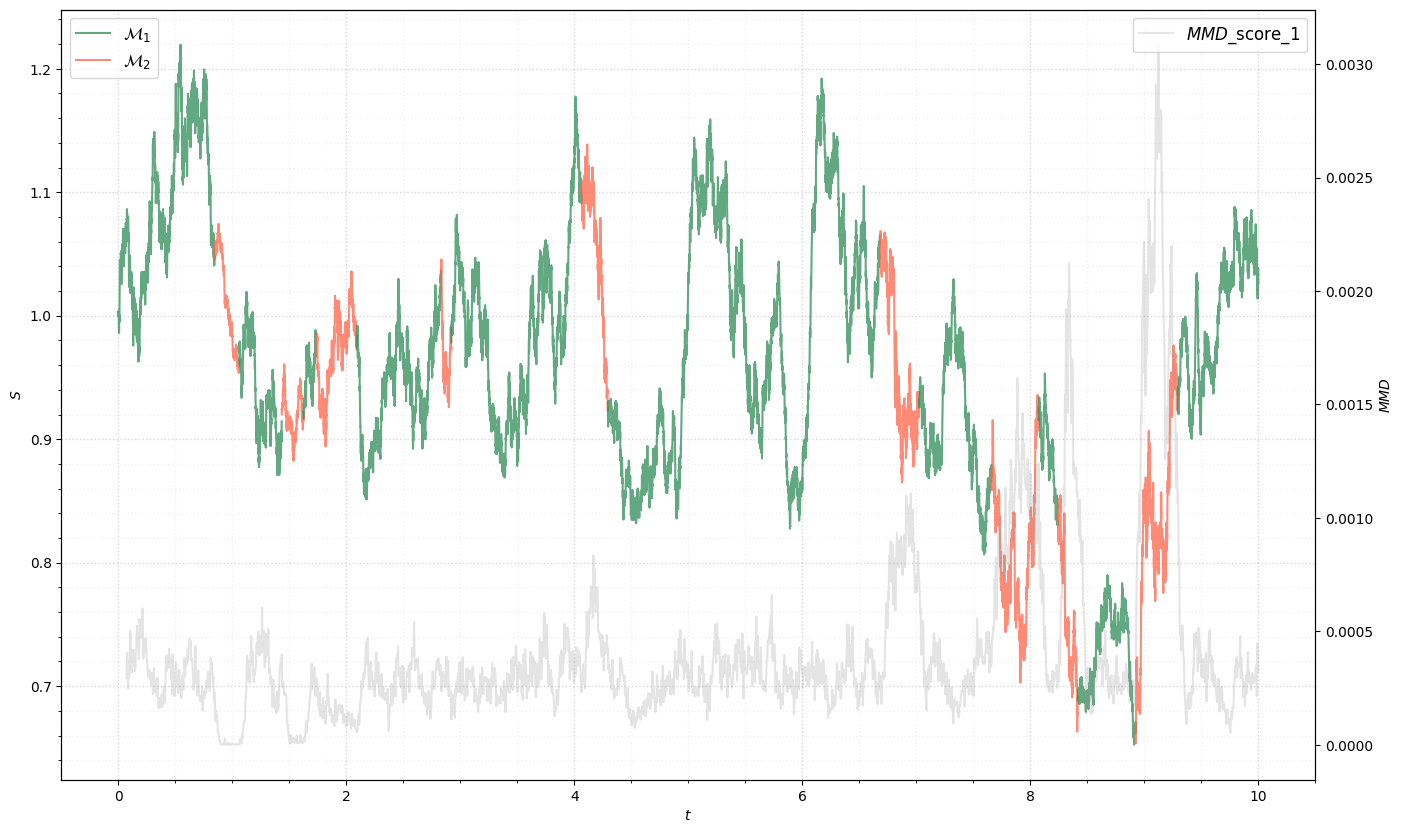

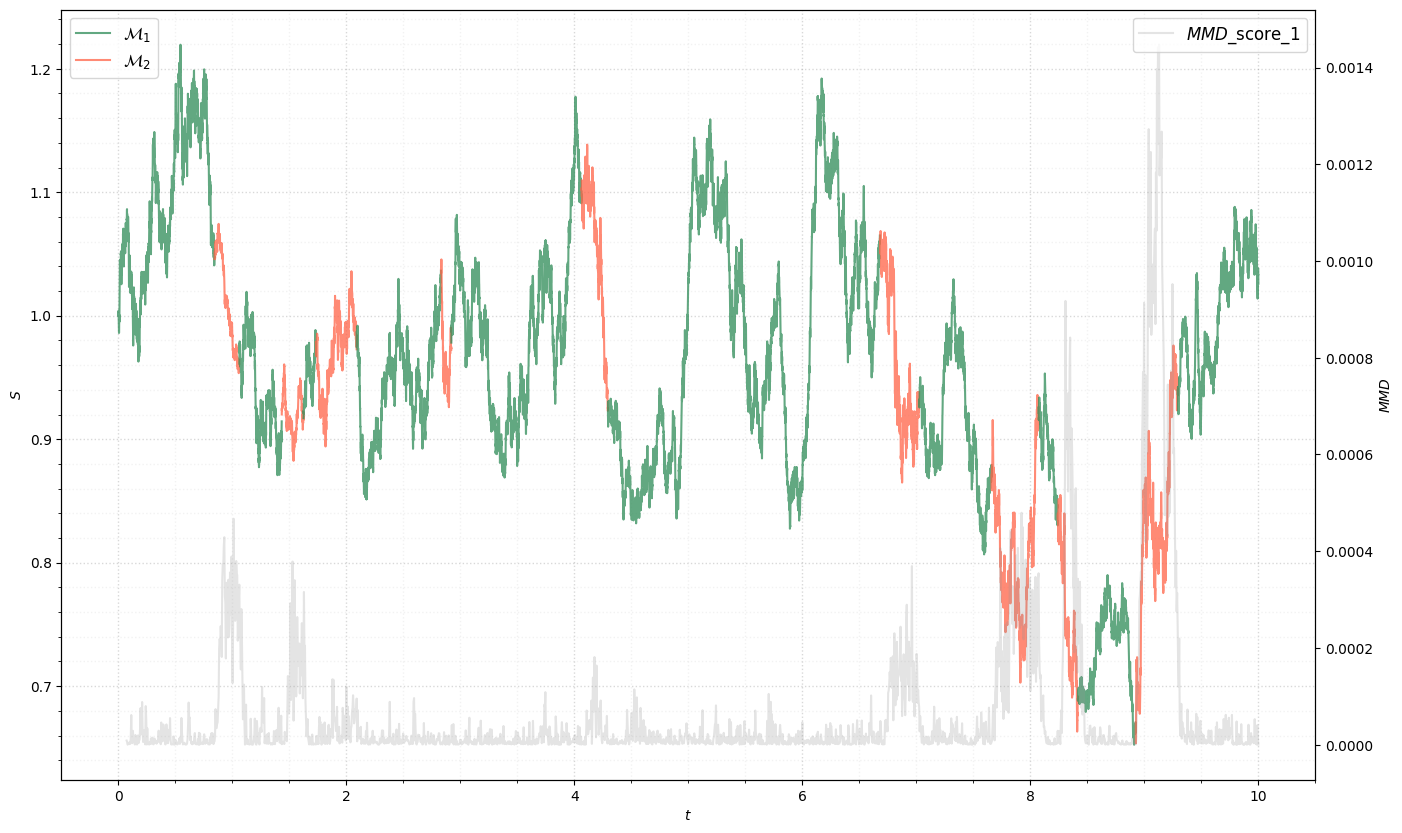

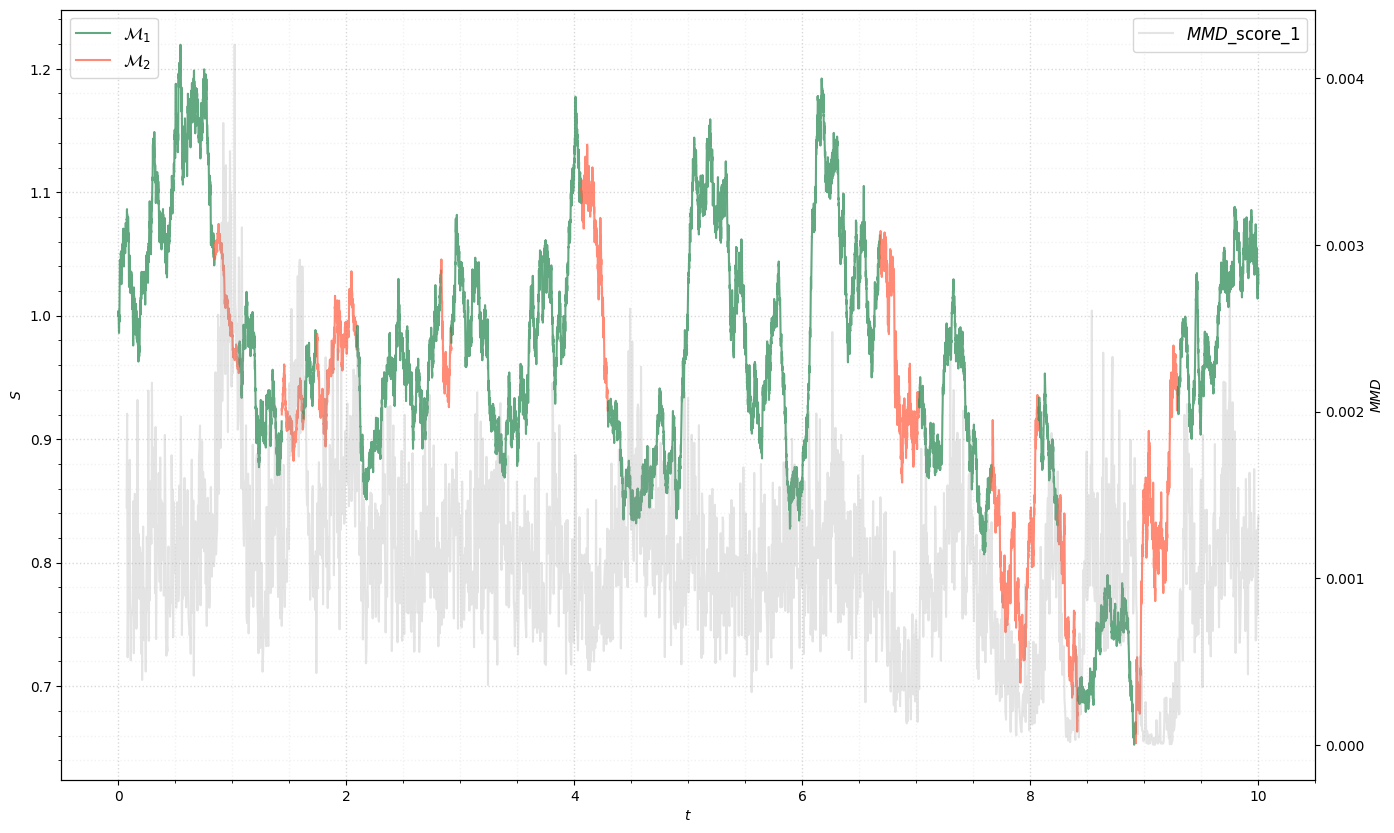

In [27]:
# Plot MMD scores
index = multiclass_score_array[0, :]

for score in multiclass_score_array[1:, :]:
    this_score_array = np.vstack([index, score])
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)

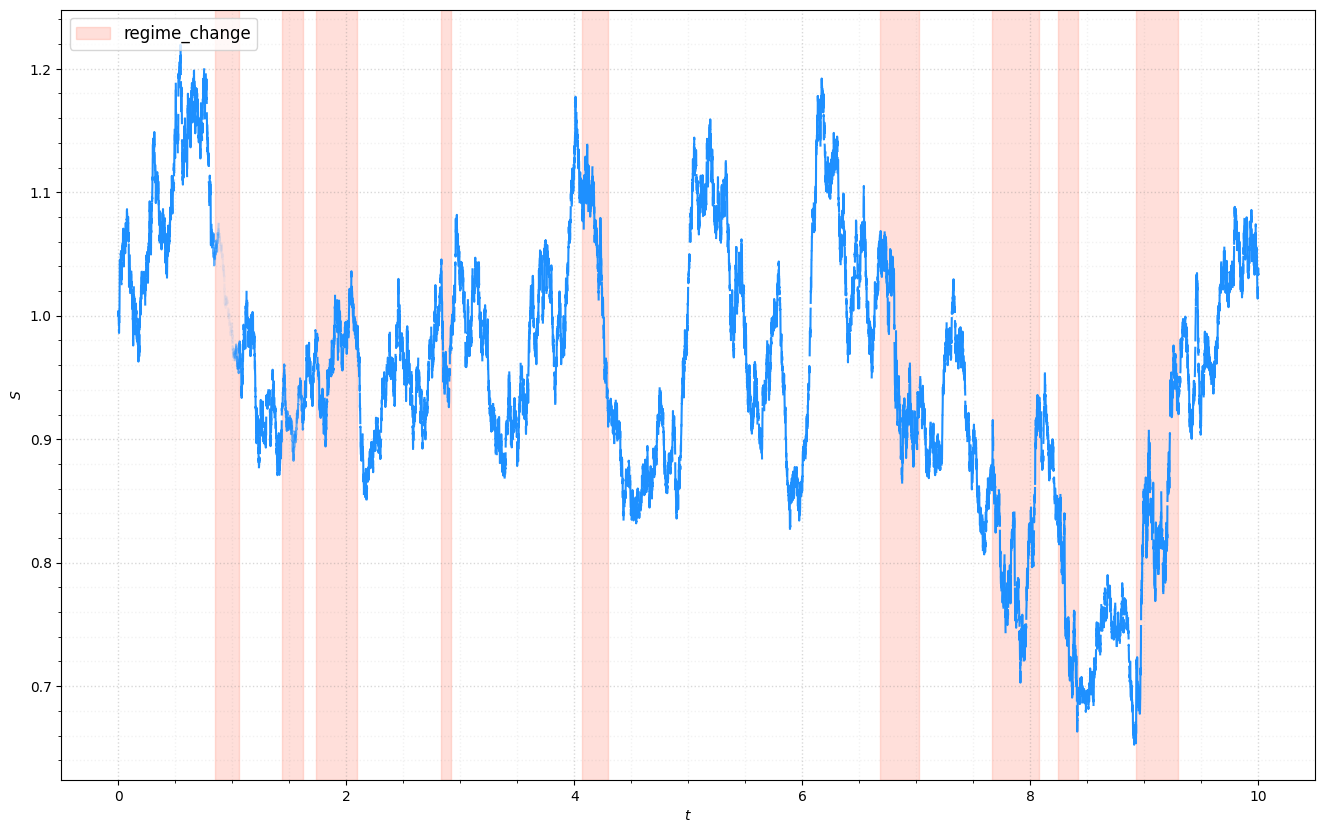

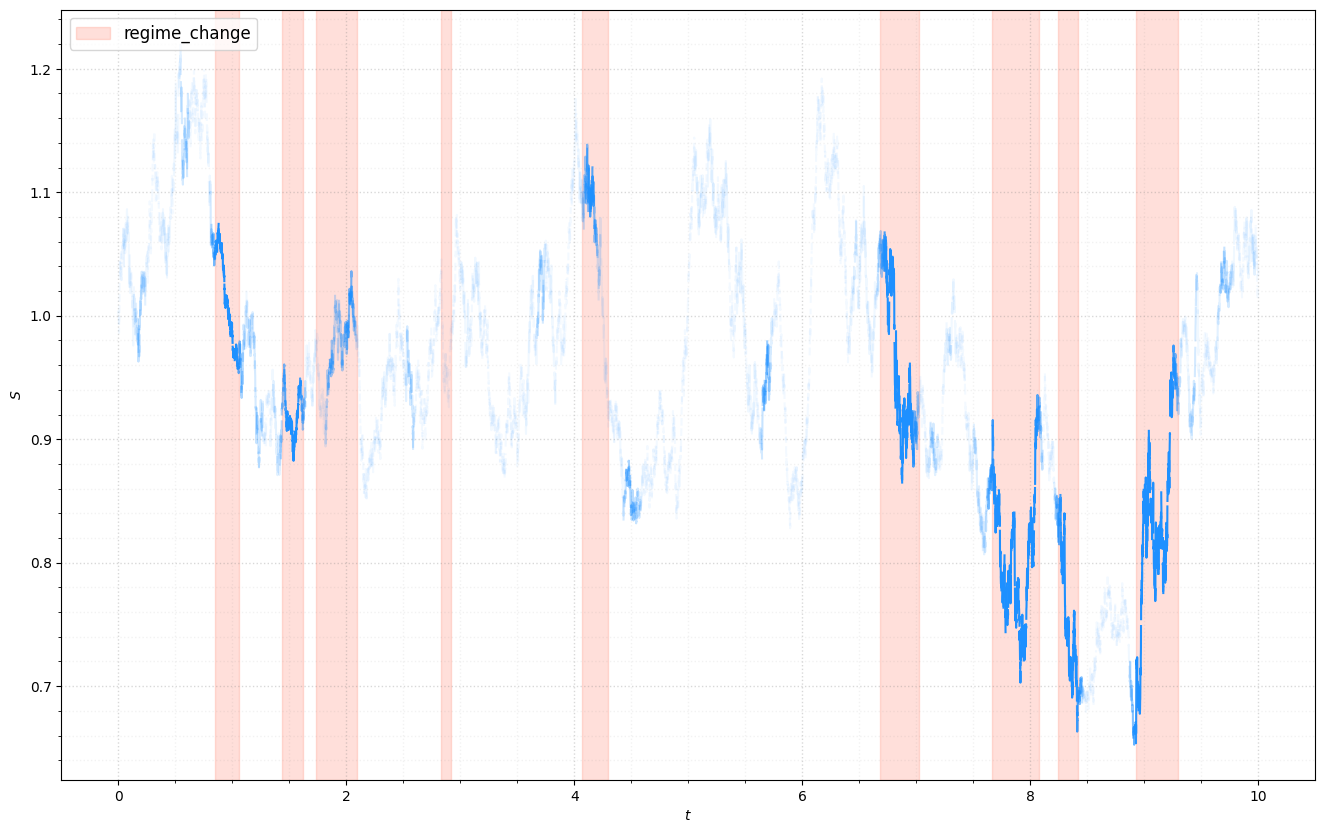

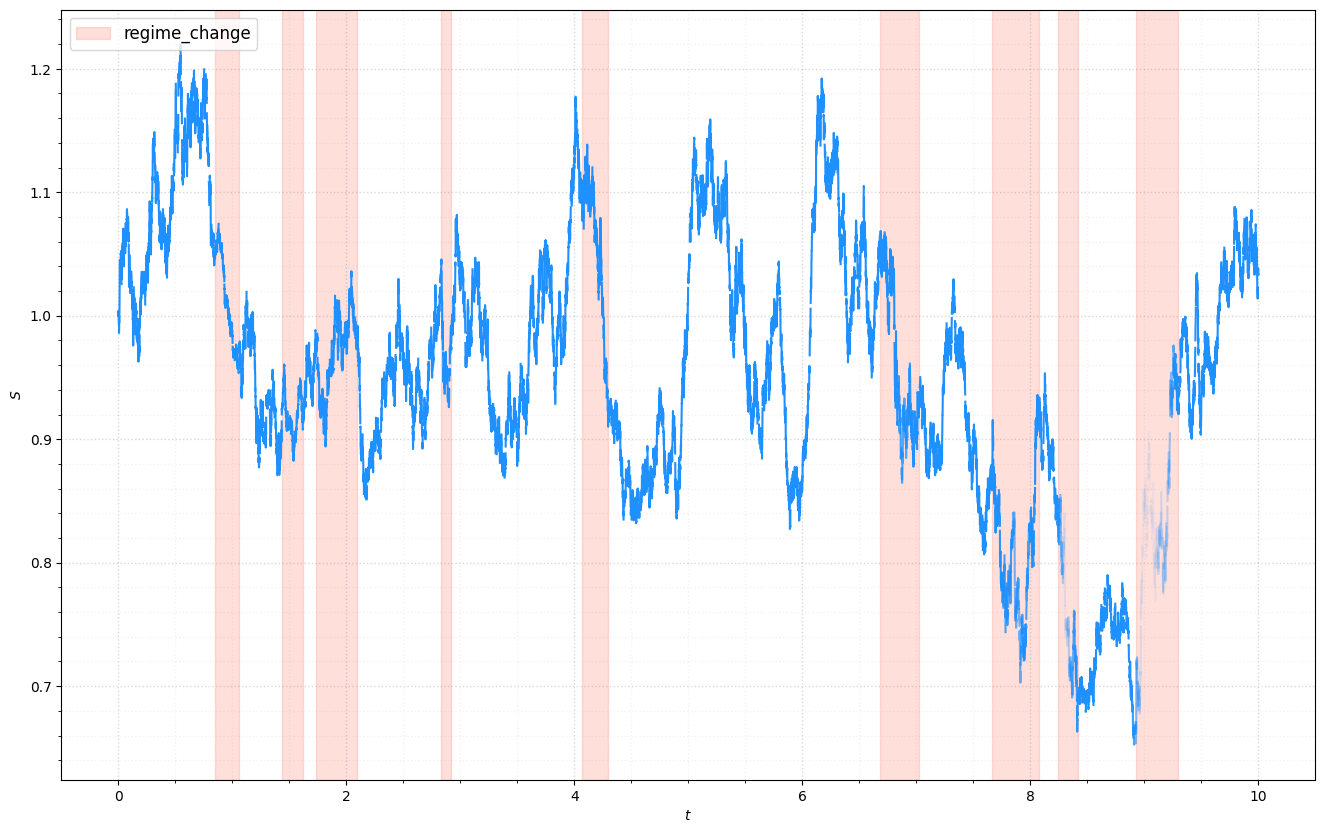

In [28]:
# Plot test threshold performance
for alphas in mmd_alphas_g:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

In [29]:
for i, alph_ in enumerate(mmd_alphas_g):

    this_score_dict = alpha_score_function(
        regime_changes = regime_partitioner.regime_changes, 
        path_length    = len(test_path), 
        memberships    = memberships,
        test_alphas    = alph_,
        test_data      = [test_config.n_steps, test_config.offset, _n_paths]
    )

    print(f"\nSigker scores, belief {i+1}")
    for k, v in this_score_dict.items():
        print("{}: {:.4f}%".format(k, v*100))


Sigker scores, belief 1
regime_on: 91.5204%
regime_off: 0.0708%
total: 21.9274%

Sigker scores, belief 2
regime_on: 74.0987%
regime_off: 93.5063%
total: 88.8678%

Sigker scores, belief 3
regime_on: 81.5821%
regime_off: 0.1155%
total: 19.5862%
